## Calculating deforestation rate for selected Tropical Forest sites🌳📈

#### Goal: 
to compare deforestation rates of the REDD+ research sites and their vicinities over the period of 2009-2022

#### Data:
- 'Annual change' products belonging to JRC Tropical Moist Forests initiative [1], disributed in a TIFF format
- research sites' boundaries supplied with the information on the year of monitoring start, in a Shapefile format

#### Research area & time: 
8 research sites located in the Tropical Forest, in northwestern part of Brazil 

#### Processing steps:
1. Initial preparation
2. Calculating the deforestation rate
3. Visualizing example research area's deforestation characteristics

#### Sources: 
[1] Joint Research Centre Tropical Moist Forest - Data Users Guide (v1) available at: https://forobs.jrc.ec.europa.eu/static/tmf/TMF_DataUsersGuide.pdf

Prepared by: Aleksandra Radecka <br>
e-mail: aleksandraradecka@protonmail.com <br> 
LinkedIn: https://www.linkedin.com/in/aleksandraradecka/

## 1. Initial preparation
- Importing all of the necessary Python packages

In [39]:
import glob
import os
import re
import zipfile

import geopandas as gpd
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.merge import merge
import rasterstats

- Unzippping all of the files

In [2]:
input_data_folder = 'reddplus_project/input_data'

In [3]:
zip_file_paths = glob.glob(os.path.join(input_data_folder, '*.zip'))

In [4]:
zip_file_paths

['reddplus_project/input_data/JRC_TMF_AnnualChange_v1_SAM_ID30_N0_W60.zip',
 'reddplus_project/input_data/project_sites.zip',
 'reddplus_project/input_data/JRC_TMF_AnnualChange_v1_SAM_ID29_N0_W70.zip']

In [5]:
for zip_fp in zip_file_paths:
    with zipfile.ZipFile(zip_fp, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(input_data_folder, zip_fp.split('/')[-1].split('.')[0]))

- Familiarizing with the data

In [6]:
project_sites = gpd.read_file(os.path.join(input_data_folder, 'project_sites/project.shp'))

In [7]:
project_sites

,FID,startyr,geometry
0,0,2011,"POLYGON ((-62.01455 -6.39238, -62.01441 -6.392..."
1,1,2010,"MULTIPOLYGON (((-59.81900 -5.88759, -59.81900 ..."
2,2,2015,"POLYGON ((-59.97065 -4.94739, -59.90821 -4.924..."
3,3,2009,"MULTIPOLYGON (((-59.69491 -7.27077, -59.69503 ..."
4,4,2017,"POLYGON ((-62.15262 -5.53672, -62.15403 -5.535..."
5,5,2018,"POLYGON ((-60.65110 -5.30549, -60.62875 -5.305..."
6,6,2015,"MULTIPOLYGON (((-60.54688 -6.49465, -60.67603 ..."
7,7,2013,"MULTIPOLYGON (((-59.48343 -5.95128, -59.48362 ..."


In [8]:
project_sites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
annual_change_W60_2022_ds = rio.open(glob.glob(os.path.join(input_data_folder, '**/*AnnualChange*2022*W60.tif'), recursive = True)[0])

In [10]:
annual_change_W60_2022_ds.crs

CRS.from_epsg(4326)

In [11]:
annual_change_W60_2022 = annual_change_W60_2022_ds.read(1)

In [12]:
annual_change_W60_2022

array([[1, 1, 1, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 6, 6],
       ...,
       [1, 1, 1, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 6, 6],
       [1, 1, 1, ..., 6, 6, 6]], dtype=uint8)

In [13]:
# RGB color codes for classes 1-6 (and 0 at the beginning), following the symbology defined for 'Annual change collection' in [1]
rgb_colors = [(0, 0, 0), (0, 90, 0), (100, 155, 35), (255, 135, 15), (210, 250, 60), (0, 140, 190), (255, 255, 255)]

In [14]:
rgb_colors_norm = [(r / 255, g / 255, b / 255) for r, g, b in rgb_colors]

In [16]:
labels = ['no data', 'Undisturbed tropical moist forest', 'Degraded tropical moist forest', 'Deforested land', 
         'Tropical moist forest regrowth', 'Permanent and seasonal water', 'Other land cover'] # from [1]

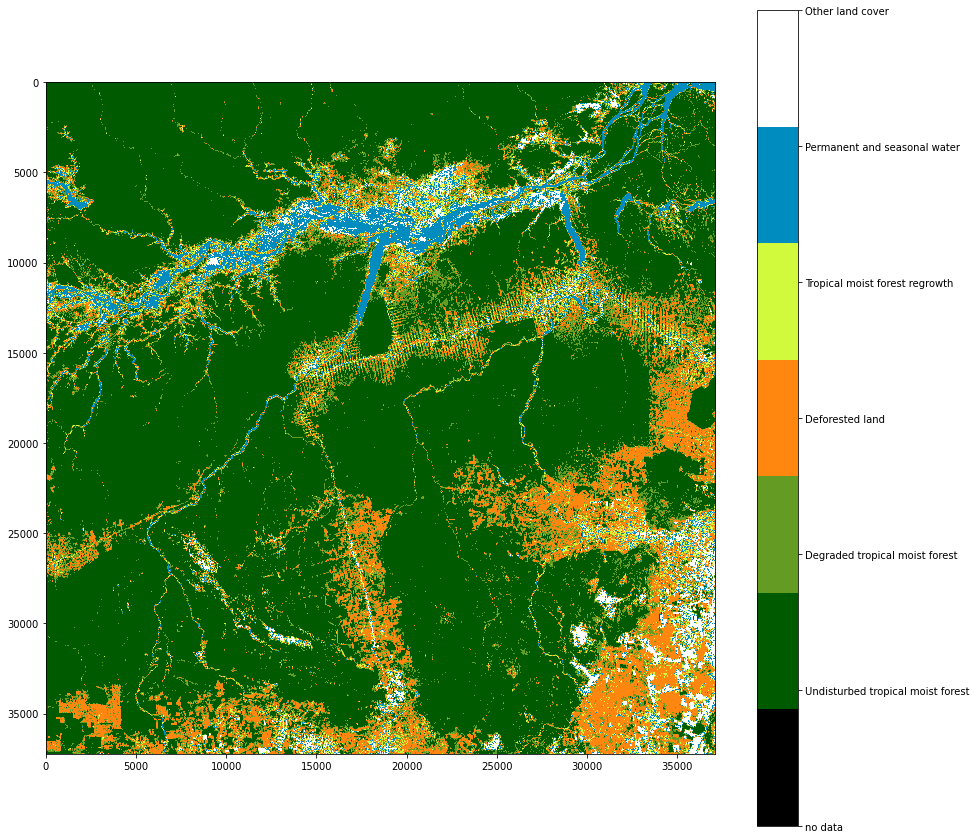

In [20]:
cmap = clrs.ListedColormap(rgb_colors_norm)
plt.figure(figsize = (15,15))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 6))
sm.set_array([])
cb = plt.colorbar(sm)
plt.imshow(annual_change_W60_2022, cmap=cmap)
cb.set_ticks(range(len(labels)))
cb.set_ticklabels(labels)

plt.savefig('annual_change_2022.png', dpi=300)
plt.show();

## 2. Calculating the deforestation rate

- Selecting the earliest project start year of all project sites

In [21]:
earliest_year = project_sites['startyr'].min()
earliest_year

2009

- Creating mosaiced 'Annual change collection' rasters for each year (starting from the earlies needed) and reclassifying them 

In [22]:
reclassified_mosaic_paths = []

for yr in range(earliest_year, 2023):
    # find W60 & W70 rasters
    raster_paths = glob.glob(os.path.join(input_data_folder, '**/*AnnualChange*' + str(yr) + '*.tif'), recursive = True)
    # creating rasterio dataset objects
    raster_ds = [rio.open(rp) for rp in raster_paths]
    # performing the mosaic
    mosaic, out_trans = merge(raster_ds)
    # reclassifying mosaic to values: 1 > undisturbed & degraded forest, 2 > rest
    mosaic_reclassified = np.where(mosaic <= 2, 1, 2)
    # updating the metadata
    out_meta = raster_ds[0].meta.copy()
    out_meta.update({"height": mosaic.shape[1],
                     "width": mosaic.shape[2]})
    # saving the mosaic and reclassified mosaic to disc, appending path to the second
    m_output_path = 'reddplus_project/mosaic_' + str(yr) + '.tif'
    rm_output_path = 'reddplus_project/reclassified_mosaic_' + str(yr) + '.tif'
    
    with rio.open(m_output_path, "w", **out_meta) as dest:
        dest.write(mosaic)
    with rio.open(rm_output_path, "w", **out_meta) as dest:
        dest.write(mosaic_reclassified)
    reclassified_mosaic_paths.append(rm_output_path)

- Creating a polygonal layer containing 50-km buffers around each project site

In [23]:
project_sites_utm = project_sites.to_crs('EPSG:32720') # transformatio between geographic and cartographic CRS in order to enable defining the buffer in meters

In [24]:
project_buffers_utm = project_sites_utm.copy() 

In [25]:
project_buffers_utm['geometry'] = project_buffers_utm.geometry.buffer(50000) # overwriting the geometry to preserve attributes

In [26]:
project_vicinities_utm = gpd.overlay(project_buffers_utm, project_sites_utm, how='difference') # deleting the common part between sites and their buffers

In [27]:
project_vicinities_utm

,FID,startyr,geometry
0,0,2011,"POLYGON ((593799.200 9160059.263, 591334.964 9..."
1,1,2010,"MULTIPOLYGON (((864661.728 9299775.057, 864600..."
2,2,2015,"POLYGON ((782570.319 9457954.613, 782817.783 9..."
3,3,2009,"POLYGON ((880853.354 9144619.671, 880368.622 9..."
4,4,2017,"MULTIPOLYGON (((746061.481 9357126.712, 746065..."
5,5,2018,"MULTIPOLYGON (((669733.145 9393021.323, 672220..."
6,6,2015,"MULTIPOLYGON (((815402.718 9456332.618, 816922..."
7,7,2013,"MULTIPOLYGON (((802351.022 9352663.869, 802228..."


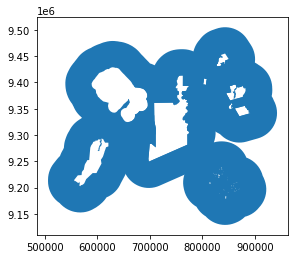

In [28]:
project_vicinities_utm.plot();

In [29]:
project_vicinities = project_vicinities_utm.to_crs('EPSG:4326')

- Calculating the % of forst cover for each research area (rows 0-7) and year (both for sites and their vicinities)

In [30]:
stats_df = pd.DataFrame()

In [31]:
area_types = {'site': project_sites, 'vicinity': project_vicinities}

In [32]:
for rm in reclassified_mosaic_paths:
    for at in area_types:

        zonal_stats = rasterstats.zonal_stats(area_types[at], rm, categorical=True)
        forest_cover = [round(zonal_stats[i][1] / (zonal_stats[i][1] + zonal_stats[i][2]) * 100, 2) for i in range(0, 8)]
        stats_df[at + '_' + re.split(r'[_.]', rm)[-2]] = forest_cover

/home/CENAGIS/aradecka/.local/lib/python3.7/site-packages/rasterstats/io.py:329: NodataWarning: Setting nodata to -999; specify nodata explicitly
  "Setting nodata to -999; specify nodata explicitly", NodataWarning


In [33]:
stats_df

,site_2009,vicinity_2009,site_2010,vicinity_2010,site_2011,vicinity_2011,site_2012,vicinity_2012,site_2013,vicinity_2013,...,site_2018,vicinity_2018,site_2019,vicinity_2019,site_2020,vicinity_2020,site_2021,vicinity_2021,site_2022,vicinity_2022
0,99.70,93.03,99.70,92.90,99.68,92.68,99.68,92.60,99.66,92.47,...,99.55,91.52,99.52,91.48,99.50,91.34,99.48,91.14,99.48,91.06
1,99.85,97.01,99.85,96.95,99.85,96.92,99.83,96.86,99.82,96.71,...,99.78,95.75,99.77,95.66,99.77,95.53,99.76,95.12,99.75,94.68
2,99.69,94.64,99.64,94.59,99.61,94.55,99.59,94.49,99.57,94.43,...,99.18,93.76,99.17,93.70,99.13,93.58,99.07,93.30,99.05,93.03
3,98.68,92.00,98.60,91.52,98.55,91.34,98.49,90.87,98.36,90.42,...,97.54,86.44,97.49,85.45,97.33,84.55,97.08,82.83,96.29,81.28
4,93.59,95.17,93.54,95.09,93.48,95.05,93.42,95.01,93.35,94.94,...,92.66,94.34,92.62,94.32,92.55,94.25,92.49,94.21,92.39,94.08
5,98.19,94.38,98.14,94.30,98.10,94.25,98.05,94.20,97.91,94.10,...,97.52,93.36,97.52,93.33,97.48,93.22,97.45,93.08,97.43,92.88
6,96.23,95.99,96.18,95.95,96.13,95.91,96.04,95.86,95.80,95.78,...,95.14,95.29,95.13,95.25,95.12,95.16,94.89,94.98,94.89,94.75
7,99.91,97.71,99.91,97.66,99.91,97.65,99.91,97.60,99.91,97.50,...,99.90,96.83,99.90,96.76,99.90,96.66,99.90,96.37,99.89,96.05


In [34]:
stats_df.reset_index(inplace=True)

In [35]:
stats_df = stats_df.rename(columns={'index': 'FID'})

In [36]:
stats_df

,FID,site_2009,vicinity_2009,site_2010,vicinity_2010,site_2011,vicinity_2011,site_2012,vicinity_2012,site_2013,...,site_2018,vicinity_2018,site_2019,vicinity_2019,site_2020,vicinity_2020,site_2021,vicinity_2021,site_2022,vicinity_2022
0,0,99.70,93.03,99.70,92.90,99.68,92.68,99.68,92.60,99.66,...,99.55,91.52,99.52,91.48,99.50,91.34,99.48,91.14,99.48,91.06
1,1,99.85,97.01,99.85,96.95,99.85,96.92,99.83,96.86,99.82,...,99.78,95.75,99.77,95.66,99.77,95.53,99.76,95.12,99.75,94.68
2,2,99.69,94.64,99.64,94.59,99.61,94.55,99.59,94.49,99.57,...,99.18,93.76,99.17,93.70,99.13,93.58,99.07,93.30,99.05,93.03
3,3,98.68,92.00,98.60,91.52,98.55,91.34,98.49,90.87,98.36,...,97.54,86.44,97.49,85.45,97.33,84.55,97.08,82.83,96.29,81.28
4,4,93.59,95.17,93.54,95.09,93.48,95.05,93.42,95.01,93.35,...,92.66,94.34,92.62,94.32,92.55,94.25,92.49,94.21,92.39,94.08
5,5,98.19,94.38,98.14,94.30,98.10,94.25,98.05,94.20,97.91,...,97.52,93.36,97.52,93.33,97.48,93.22,97.45,93.08,97.43,92.88
6,6,96.23,95.99,96.18,95.95,96.13,95.91,96.04,95.86,95.80,...,95.14,95.29,95.13,95.25,95.12,95.16,94.89,94.98,94.89,94.75
7,7,99.91,97.71,99.91,97.66,99.91,97.65,99.91,97.60,99.91,...,99.90,96.83,99.90,96.76,99.90,96.66,99.90,96.37,99.89,96.05


In [37]:
project_sites = project_sites.merge(stats_df, on="FID")

In [38]:
project_sites

,FID,startyr,geometry,site_2009,vicinity_2009,site_2010,vicinity_2010,site_2011,vicinity_2011,site_2012,...,site_2018,vicinity_2018,site_2019,vicinity_2019,site_2020,vicinity_2020,site_2021,vicinity_2021,site_2022,vicinity_2022
0,0,2011,"POLYGON ((-62.01455 -6.39238, -62.01441 -6.392...",99.70,93.03,99.70,92.90,99.68,92.68,99.68,...,99.55,91.52,99.52,91.48,99.50,91.34,99.48,91.14,99.48,91.06
1,1,2010,"MULTIPOLYGON (((-59.81900 -5.88759, -59.81900 ...",99.85,97.01,99.85,96.95,99.85,96.92,99.83,...,99.78,95.75,99.77,95.66,99.77,95.53,99.76,95.12,99.75,94.68
2,2,2015,"POLYGON ((-59.97065 -4.94739, -59.90821 -4.924...",99.69,94.64,99.64,94.59,99.61,94.55,99.59,...,99.18,93.76,99.17,93.70,99.13,93.58,99.07,93.30,99.05,93.03
3,3,2009,"MULTIPOLYGON (((-59.69491 -7.27077, -59.69503 ...",98.68,92.00,98.60,91.52,98.55,91.34,98.49,...,97.54,86.44,97.49,85.45,97.33,84.55,97.08,82.83,96.29,81.28
4,4,2017,"POLYGON ((-62.15262 -5.53672, -62.15403 -5.535...",93.59,95.17,93.54,95.09,93.48,95.05,93.42,...,92.66,94.34,92.62,94.32,92.55,94.25,92.49,94.21,92.39,94.08
5,5,2018,"POLYGON ((-60.65110 -5.30549, -60.62875 -5.305...",98.19,94.38,98.14,94.30,98.10,94.25,98.05,...,97.52,93.36,97.52,93.33,97.48,93.22,97.45,93.08,97.43,92.88
6,6,2015,"MULTIPOLYGON (((-60.54688 -6.49465, -60.67603 ...",96.23,95.99,96.18,95.95,96.13,95.91,96.04,...,95.14,95.29,95.13,95.25,95.12,95.16,94.89,94.98,94.89,94.75
7,7,2013,"MULTIPOLYGON (((-59.48343 -5.95128, -59.48362 ...",99.91,97.71,99.91,97.66,99.91,97.65,99.91,...,99.90,96.83,99.90,96.76,99.90,96.66,99.90,96.37,99.89,96.05


## 3. Visualizing example research area's deforestation characteristics

In [44]:
project_sites_area3 = project_sites.iloc[3, 3:]

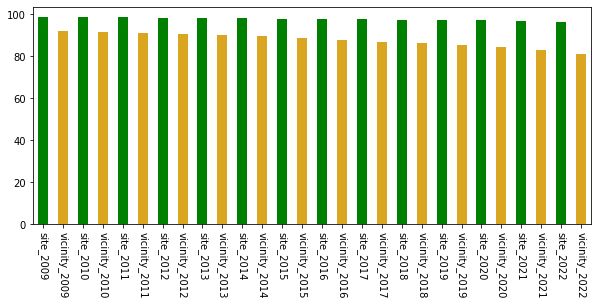

In [51]:
project_sites_area3.plot.bar(rot=270, color=['green', 'goldenrod'], figsize=(10, 4));

The results show that indeed, the aim of the project was achieved - sites being part of the project were less affected by deforestation than their vicinities.

#### Comments:
- <u>Tools:</u> I decided to use the simplest and most straightforward tools - GeoPandas, Rasterio and Rasterstats. It is however possible to do the calculations quicker e.g. using Xarray and Dask. 
- <u>Border pixels:</u> By default, Rasterstats calculates zonal statistics based on pixels whose centers lie within the polygon feature (source: https://pythonhosted.org/rasterstats/rasterstats.html). The obtained areas may therefore not be fully consistent with the project site's area. I decided the effect is negligible in this scale and does not require to be corrected.
- <u>Last plot:</u> Last plot could be imporoved by using year as a pd.DataFrame index and removing it from the columns names'. 